In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from torchdiffeq import odeint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from typing import Tuple, Callable
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def get_data(n_samples: int =1024) -> Tuple[torch.Tensor]:
    x, _ = make_moons(n_samples=n_samples, noise=0.1)
    # x, _ = make_circles(n_samples=n_samples, noise=0.1)
    return torch.tensor(x, dtype=torch.float32)

def divergence_approx(f: Callable, z: torch.Tensor) -> torch.Tensor:
    e = torch.randn_like(z)
    grad = torch.autograd.grad(
        outputs=f,
        inputs=z,
        grad_outputs=e,
        create_graph=True,  # autograd 결과값(gradient)을 단순 숫자가 아닌, inputs의 함수로 보고 다시 미분 가능한 계산 그래프를 생성함. default=False
        # retain_graph=True  # autograd 이후에도 계산 그래프를 삭제하지 않고 유지하여 같은 연산 그래프를 다시 사용할 수 있도록 함. default=False
    )[0]
    return torch.sum(grad * e, dim=1)

def exact_divergence(f: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
    """
    f: (B, D) tensor representing f(z) evaluated at batch of z
    z: (B, D) tensor, input w.r.t. which divergence is computed

    Returns: (B,) tensor of divergences
    """
    div = torch.zeros(z.shape[0], device=z.device)
    for i in range(z.shape[1]):  # over dimensions
        grad = torch.autograd.grad(
            f[:, i].sum(),  # sum over batch dimension
            z,
            create_graph=True,
            retain_graph=True
        )[0][:, i]
        div += grad
    return div

def standard_normal_logprob(z: torch.Tensor) -> torch.Tensor:
    return -0.5 * (z.pow(2) + torch.log(2 * torch.pi * torch.ones_like(z)))

def sample(model, num_samples=1000, dim=2):
    z1 = torch.randn(num_samples, dim, device=device).requires_grad_()
    logp1 = standard_normal_logprob(z1).sum(1).requires_grad_()

    # 시간 반대로 integration
    t = torch.tensor([1., 0.], device=device).requires_grad_()

    # odeint를 통해 z1 → z0 (data space로 pushforward)
    zt, logpt = odeint(model.odefunc, (z1, logp1), t, rtol=1e-8, atol=1e-8, method='rk4')
    z0, logp0 = zt[-1], logpt[-1]

    return z0  # shape: (num_samples, dim)

In [3]:
class CNFDynamics(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
        # 논문에 따라 마지막 weight 초기화
        self.net[-1].weight.data *= 0.01

    def forward(self, t, z):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, dtype=z.dtype, device=z.device)
        t_vec = t.expand(z.shape[0], 1)
        zt = torch.cat([z, t_vec], dim=1)
        return self.net(zt)

class ODEFunc(nn.Module):
    def __init__(self, dynamics, exact_div = True):
        super().__init__()
        self.dynamics = dynamics
        self.exact_div = exact_div
    def forward(self, t, state: Tuple[torch.Tensor]):
        z, logp = state
        dzdt = self.dynamics(t, z)
        if self.exact_div:
            dlogpdt = -exact_divergence(dzdt, z)
        else:
            dlogpdt = -divergence_approx(dzdt, z)
        return dzdt, dlogpdt

class CNF(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dynamics = CNFDynamics(dim)
        self.odefunc = ODEFunc(self.dynamics)

    def forward(self, z0):
        logp0 = standard_normal_logprob(z0).sum(1)
        t = torch.tensor([0., 1.], dtype=z0.dtype, device=z0.device)
        zt, logpt = odeint(self.odefunc, (z0, logp0), t, rtol=1e-8, atol=1e-8, method='rk4')
        return zt[-1], logpt[-1]

In [19]:
data = get_data().to(device)
model = CNF(dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

iter_num = 100
pbar = tqdm(range(iter_num), dynamic_ncols=True)
for epoch in pbar:
    idx = torch.randint(0, data.shape[0], (256,))
    z0 = data[idx].to(device).requires_grad_()
    zT, logpT = model(z0)
    loss = -logpT.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0 or epoch == iter_num-1:
        pbar.set_description(f"Epoch {epoch}, NLL: {loss.item():.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 99, NLL: -3.6252: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


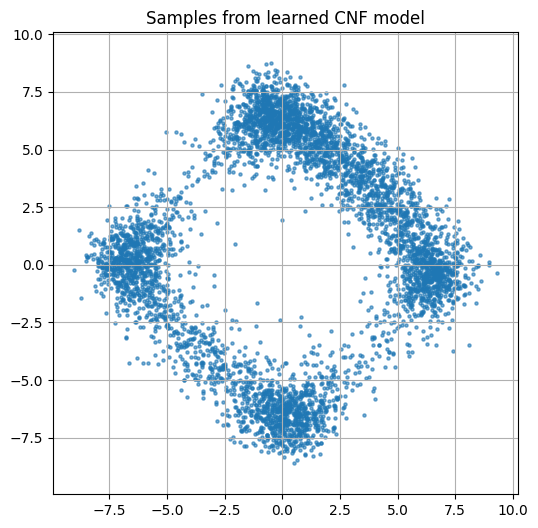

In [20]:
import matplotlib.pyplot as plt

samples = sample(model, num_samples=5000, dim=2).detach().cpu().numpy()

plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.6)
plt.title("Samples from learned CNF model")
plt.axis('equal')
plt.grid(True)
plt.show()

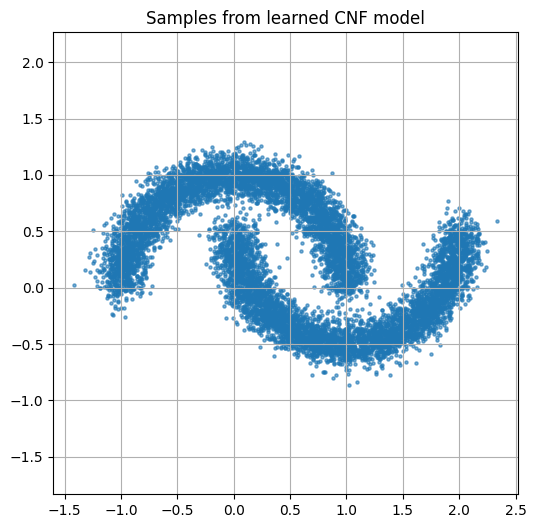

In [60]:
import matplotlib.pyplot as plt

samples = sample(model, num_samples=1000, dim=2).detach().cpu().numpy()
samples = get_data(n_samples=10000)
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.6)
plt.title("Samples from learned CNF model")
plt.axis('equal')
plt.grid(True)
plt.show()


In [6]:
class CNFDynamics(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
        self.net[-1].weight.data *= 0.01
    def forward(self, t, z):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, dtype=z.dtype, device=z.device)

        # t는 스칼라 또는 0-dim tensor
        t_vec = torch.full((z.shape[0], 1), t.item(), dtype=z.dtype, device=z.device, requires_grad=True)
        zt = torch.cat([z, t_vec], dim=1)

        return self.net(zt)


class ODEFunc(nn.Module):
    def __init__(self, dynamics):
        super().__init__()
        self.dynamics = dynamics

    def forward(self, t, state: Tuple[torch.Tensor, torch.Tensor]):
        z, logp = state
        dzdt = self.dynamics(t, z)
        dlogpdt = -divergence_approx(dzdt, z)
        return dzdt, dlogpdt

class CNF(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dynamics = CNFDynamics(dim)
        self.odefunc = ODEFunc(self.dynamics)

    def forward(self, z0):
        logp0 = standard_normal_logprob(z0).sum(1)
        t = torch.tensor([0., 1.], dtype=z0.dtype, device=z0.device)
        zt, logpt = odeint(self.odefunc, (z0, logp0), t, rtol=1e-5, atol=1e-5)
        return zt[-1], logpt[-1]

data = get_data().to(device)
model = CNF(dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1000):
    idx = torch.randint(0, data.shape[0], (256,))
    z0 = data[idx].to(device).requires_grad_()
    zT, logpT = model(z0)
    loss = -logpT.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

if epoch % 100 == 0:
    print(f"Epoch {epoch}, NLL: {loss.item():.4f}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [166]:
a = torch.tensor([1.]).requires_grad_(True)
b = torch.tensor([2.]).requires_grad_(True)

In [168]:
c = torch.cat([a,b], dim=0)
c.requires_grad

True

In [ ]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
from typing import Tuple

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === 1. CNF Dynamics ===
class CNFDynamics(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
        self.net[-1].weight.data *= 0.01

    def forward(self, t, z):
        if not isinstance(t, torch.Tensor):
            t = torch.tensor(t, dtype=z.dtype, device=z.device)

        # ✅ This works
        t_vec = torch.full((z.shape[0], 1), t.item(), dtype=z.dtype, device=z.device, requires_grad=True)
        zt = torch.cat([z, t_vec], dim=1)

        return self.net(zt)

# === 2. Divergence Approximation ===
def divergence_approx(f, z):
    e = torch.randn_like(z)
    grad = torch.autograd.grad(f, z, grad_outputs=e, create_graph=True)[0]
    return torch.sum(grad * e, dim=1)

# === 3. ODE Function ===
class ODEFunc(nn.Module):
    def __init__(self, dynamics):
        super().__init__()
        self.dynamics = dynamics

    def forward(self, t, state: Tuple[torch.Tensor, torch.Tensor]):
        z, logp = state
        dzdt = self.dynamics(t, z)
        dlogpdt = -divergence_approx(dzdt, z)
        return dzdt, dlogpdt

# === 4. CNF Wrapper ===
class CNF(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dynamics = CNFDynamics(dim)
        self.odefunc = ODEFunc(self.dynamics)

    def forward(self, z0):
        logp0 = standard_normal_logprob(z0).sum(1)
        t = torch.tensor([0., 1.], dtype=z0.dtype, device=z0.device)
        zt, logpt = odeint(self.odefunc, (z0, logp0), t, rtol=1e-5, atol=1e-5)
        return zt[-1], logpt[-1]

# === 5. Utility ===
def standard_normal_logprob(z):
    log_z = -0.5 * torch.log(torch.tensor(2 * torch.pi, dtype=z.dtype, device=z.device))
    return log_z - z.pow(2) / 2

def get_data(n=1024):
    from sklearn.datasets import make_moons
    x, _ = make_moons(n_samples=n, noise=0.1)
    return torch.tensor(x, dtype=torch.float32)

# === 6. Training ===
data = get_data().to(device)
model = CNF(dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1000):
    idx = torch.randint(0, data.shape[0], (256,))
    z0 = data[idx].to(device).requires_grad_()  # ✅ no detach
    zT, logpT = model(z0)
    loss = -logpT.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, NLL: {loss.item():.4f}")


/home/lahj91/anaconda3/envs/ddpm/lib/python3.8/site-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1724789259345/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, NLL: 2.5070


KeyboardInterrupt: 